In [11]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm, trange
import yaml
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from model import CNN_Transformer
from dataset import load_NASA, BatteryDataset

# Load the YAML configuration file
with open('config.yaml', 'r') as file:
    cfg = yaml.safe_load(file)

# # Access the variables
NUM_CYCLES = cfg['NUM_CYCLES']
FEATURE_DIM = cfg['FEATURE_DIM']
EPOCHS = cfg['EPOCHS']
LEARNING_RATE = cfg['LEARNING_RATE']
BATCH_SIZE = cfg['BATCH_SIZE']

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load data
battery_dict = load_NASA(folder='NASA_DATA', scale_data=True)
dataset = BatteryDataset(battery_dict, num_cycles=NUM_CYCLES)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# NN model
model = CNN_Transformer(feature_dim=FEATURE_DIM, num_cycles=NUM_CYCLES).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training loop
best_loss = float('inf')
model.train()

t_range = trange(EPOCHS)
for epoch in t_range:
    losses = []
    for inputs, outputs in dataloader:
        # Convert inputs and outputs to PyTorch tensors
        inputs = inputs.float().to(device)
        outputs = outputs.float().to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        predicted_outputs = model(inputs, outputs[:,:-1])

        # Compute the loss
        loss = criterion(predicted_outputs, outputs[:,-1].unsqueeze(-1))

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

        losses.append(loss.item())


    # Print the loss for monitoring after each epoch
    t_range.set_description(f"loss: {np.mean(losses)}")
    t_range.refresh()

    # Check if the current loss is the best so far
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        torch.save(model, 'trained_model.pt')

loss: 4.6694592229970214e-05: 100%|██████████| 1000/1000 [04:06<00:00,  4.05it/s]


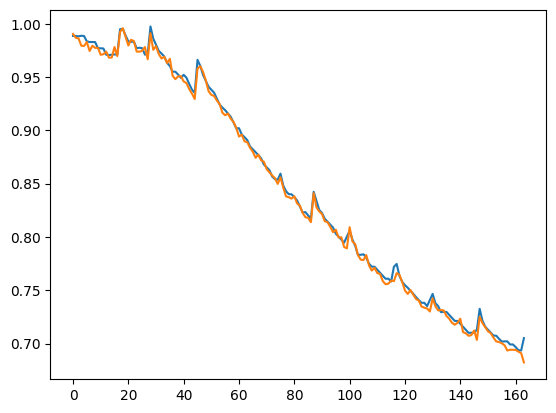

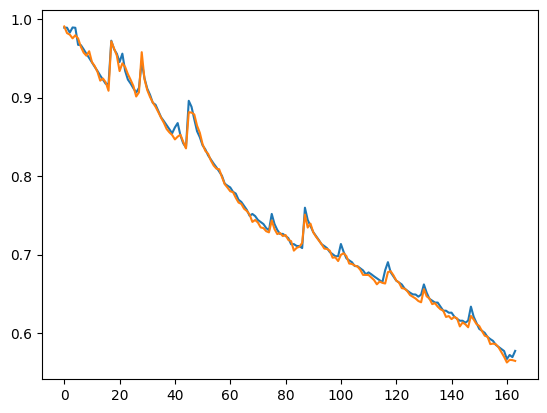

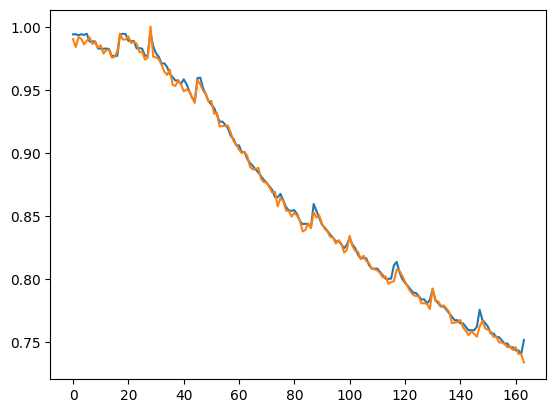

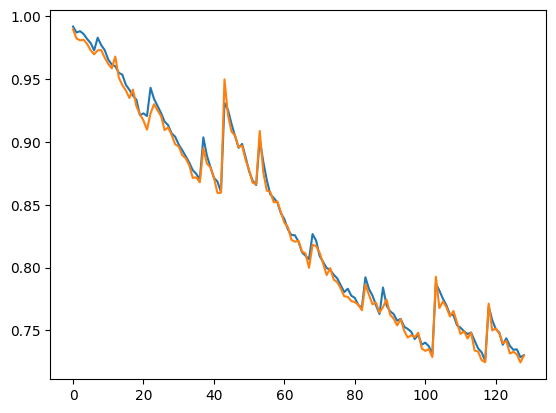

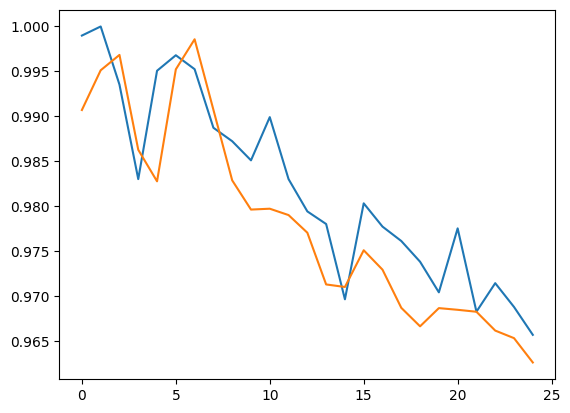

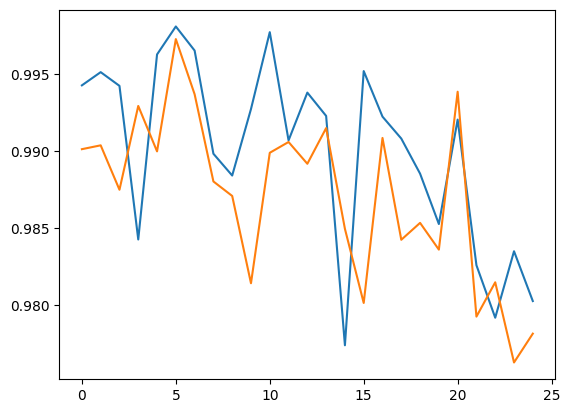

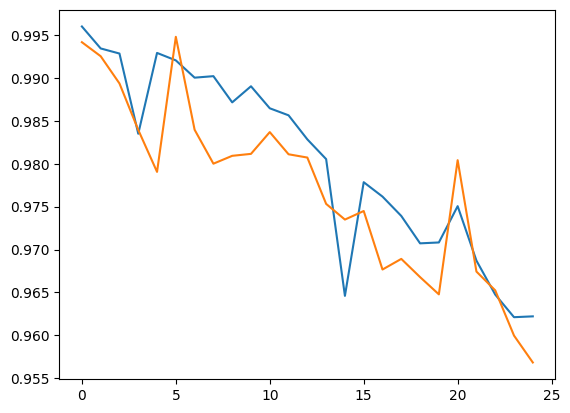

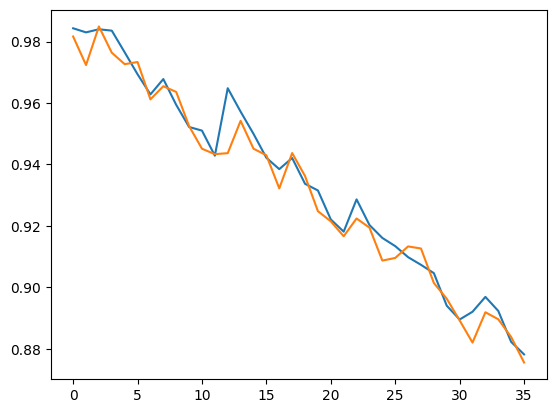

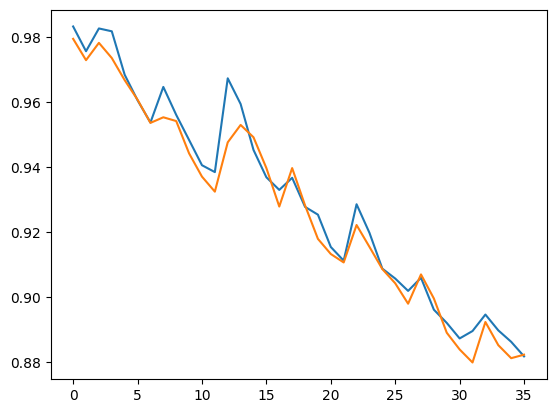

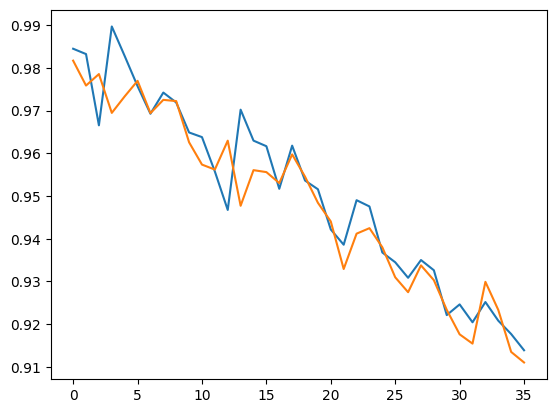

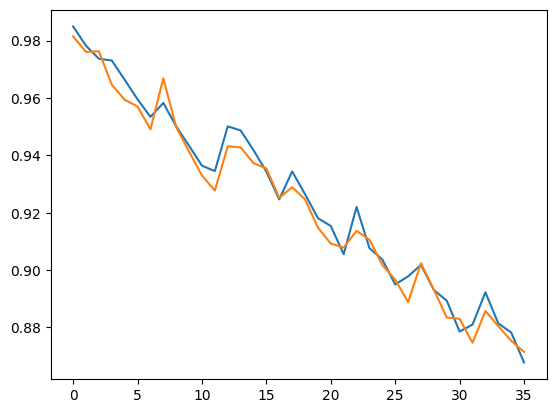

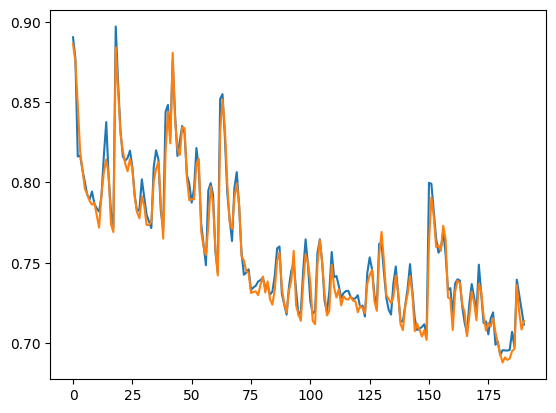

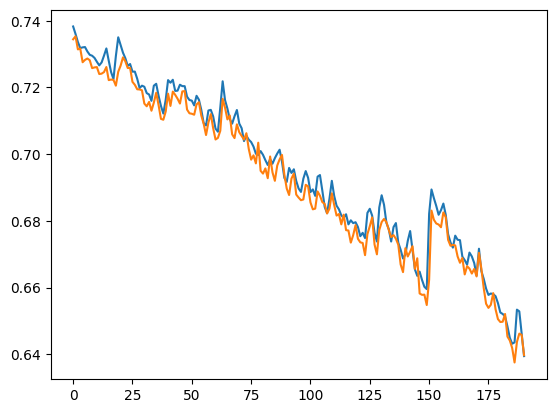

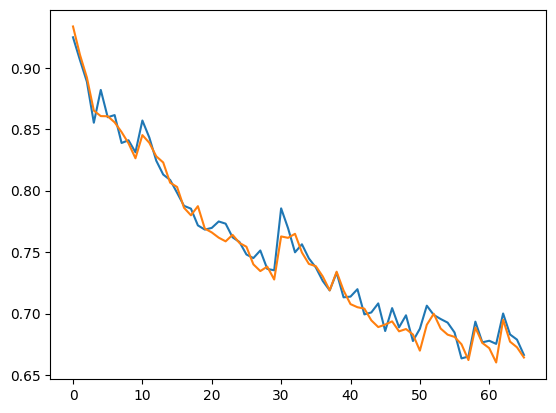

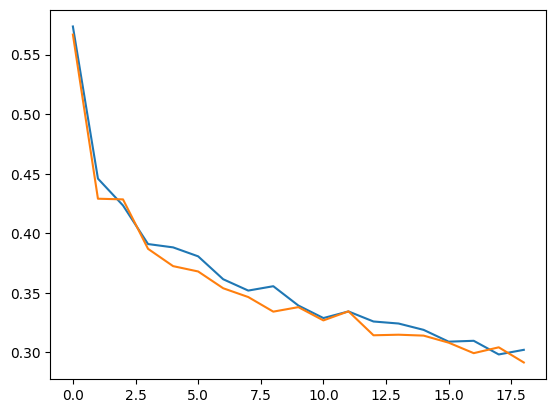

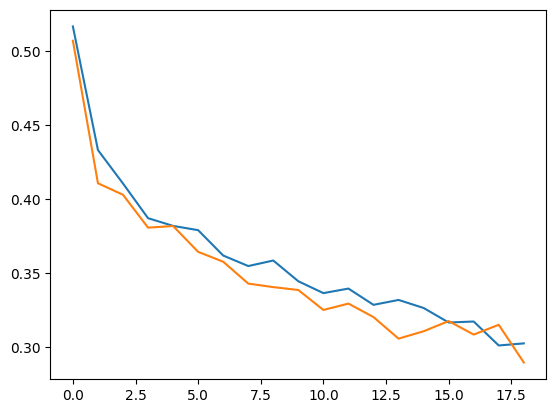

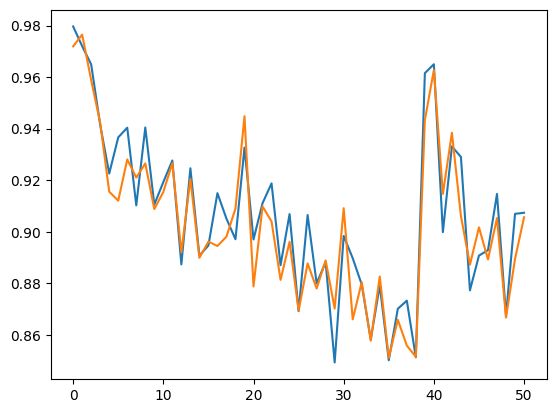

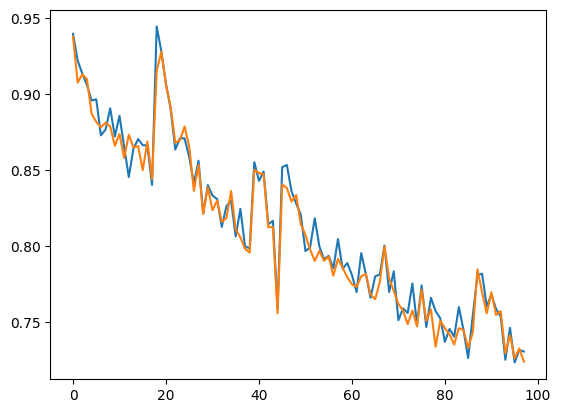

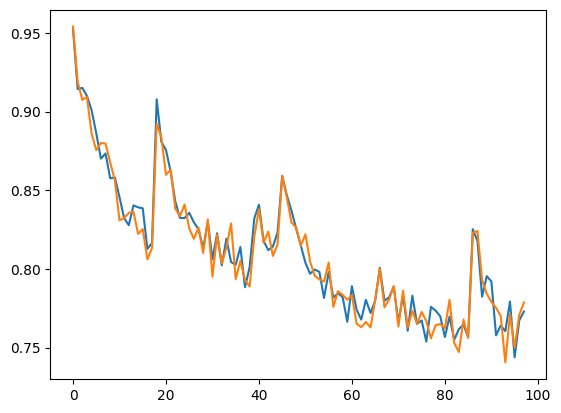

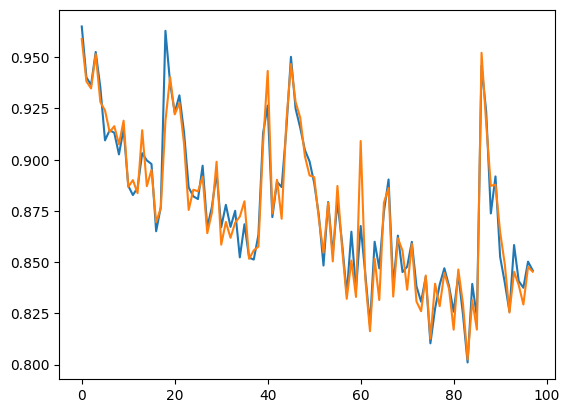

In [12]:
def plot_capacity_sequence(model, device, battery_dict, num_cycles):
    for name in battery_dict:
        soh_labels = []
        soh_preds = []
        data, caps = battery_dict[name]['data'], battery_dict[name]['cap']
        for i in range(len(data)-num_cycles):
            input_stream = data[i:i+num_cycles]
            soh_labels.append(caps[i+num_cycles-1])
            input_stream = torch.tensor(input_stream).unsqueeze(0).float().to(device)
            cap_stream = torch.tensor(caps[i:i+num_cycles-1]).unsqueeze(0).float().to(device)
            pred = model(input_stream, cap_stream)
            soh_preds.append(pred.cpu().detach().numpy())
        soh_labels = np.array(soh_labels).ravel()
        soh_preds = np.array(soh_preds).ravel()
        plt.plot(soh_labels)
        plt.plot(soh_preds)
        plt.show()

plot_capacity_sequence(model, device, battery_dict, 3)